# Deep Multispectral Demosaicing Demo

In [1]:
# Load model in ONNX format
import onnx

# Load the ONNX model
model_onnx = onnx.load("data/MSI_deep_3x3_demosaicing.onnx")

# Check that the model is well formed
onnx.checker.check_model(model_onnx)

# Print a human readable representation of the graph
# onnx.helper.printable_graph(model_onnx.graph)

In [2]:
# Load the original image (ground truth)
from Mosaicing import readMultispectralImage
gt_image_full = readMultispectralImage('data/multispectral_image_9bands.hdr', 16) / (2**16-1)
gt_image_full = gt_image_full / gt_image_full.max()
print(gt_image_full.min(),gt_image_full.max())

0.0019531846064638203 1.0


In [3]:
# Crop the input image, and apply the mosaicing effect (forward model)
from skimage.transform import resize
# gt_image = resize(gt_image, [(gt_image.shape[0]//2)*2, (gt_image.shape[1]//2)*2], order=1)
#gt_image = resize(gt_image, [512,512], order=1)

# crop the image
gt_image = gt_image_full[801:1100,151:450]

# or resize the image by a zooming factor
#zoom_factor = 0.3
#new_size = np.concatenate( ((np.array(gt_image_full.shape[0:2])*zoom_factor //2 * 2).astype(int), [gt_image_full.shape[2]]), axis=0)
#gt_image = resize(gt_image_full, new_size, order=1)

print(f'New image size : {gt_image.shape}')


New image size : (299, 299, 9)


In [4]:
# Simulating the mosaicing process and demosaicing with bilinear
from Mosaicing import mosaicing, demosaicing_generic_bilinear
import numpy as np

mosaic_image = mosaicing.mosaicing_generic(gt_image)
print('Mosaic image size', mosaic_image.shape)

image_bilinear = demosaicing_generic_bilinear(mosaic_image)
print('Bilinear image size', image_bilinear.shape)


Mosaic image size (299, 299)
Bilinear image size (299, 299, 9)


In [5]:
# Prepare the input bilinear image as a tensor
m = image_bilinear.mean()
v = image_bilinear.std()
net_input = (image_bilinear - m)/v;
net_input = np.transpose(net_input,(2,0,1))
net_input = np.array(net_input)[np.newaxis, :, :].astype(np.float32)
print(f'Network input tensor : {net_input.shape} as {net_input.dtype}')


Network input tensor : (1, 9, 299, 299) as float32


In [6]:
# Applying Network
import caffe2.python.onnx.backend as backend

prepared_backend = backend.prepare(model_onnx, device="CUDA:0")  # device is either "CUDA:0" or "CPU"
net_output = prepared_backend.run(net_input)

print('Network output tensor', net_output[0].shape)

# Convert back to image
im_output = np.transpose(net_output[0][0],(1,2,0)) * v + m
print('Output image size', im_output.shape)


CUDA operators do not support 64-bit doubles, please use arr.astype(np.float32) or np.int32 for ints. Blob: 0 type: float64


Network output tensor (1, 9, 299, 299)
Output image size (299, 299, 9)


/home/tim/miniconda3/envs/TIM_Caffe2_Python_spectral/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Deep demosaicing')

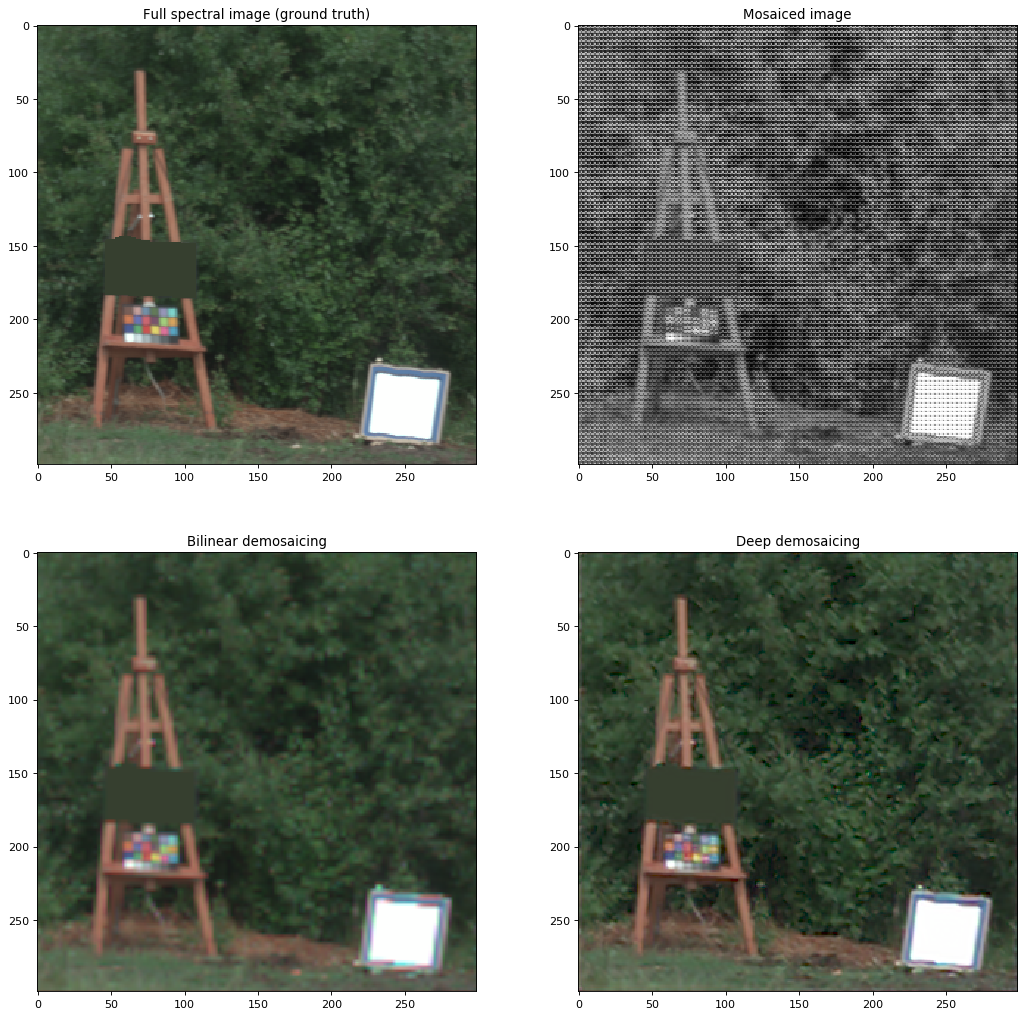

In [7]:
# Plot outputs
import matplotlib.pyplot as plt
%matplotlib inline

# RGB image band selection
red_band = 3
green_band = 1
blue_band = 0

# Figures
fig = plt.figure(figsize=(16, 16), dpi= 80)

plt.subplot('221')
plt.imshow((gt_image[:,:,[red_band, green_band, blue_band]])**0.45)
plt.title('Full spectral image (ground truth)')

plt.subplot('222')
plt.imshow(mosaic_image**0.45, cmap='gray')
plt.title('Mosaiced image')

plt.subplot('223')
plt.imshow((image_bilinear[:,:,[red_band, green_band, blue_band]])**0.45)
plt.title('Bilinear demosaicing')

plt.subplot('224')
plt.imshow((im_output[:,:,[red_band, green_band, blue_band]])**0.45)
plt.title('Deep demosaicing')
